# Plot the results from acquired data

This notebook will plot results generated by the scripte `main_large_graphs.py`.
It requires the QAOA data files which have the folowing naming convention: `{date}_{uuid}_{backend_name}_qaoa_data.json`.

In [1]:
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization.applications import Maxcut

from large_scale_qaoa import qaoa
from large_scale_qaoa.graph_utils import build_graph
from large_scale_qaoa.light_cone_qaoa import LightConeQAOA

The data below are for ibm_brisbane.

In [2]:
data_sets = [
    (10, "48c5939f", "20230709"), 
    (20, "eacf5c98", "20230709"), 
    (30, "248cbec7", "20230709"), 
    (40, "aa966dcc", "20230709")
]

backend_name = "ibm_brisbane"

# ytickpositions for the first row to avoid .5's.
yticks = [
    [-6, -4, -2, 0, 2],
    [-6, -3, 0, 3],
    [-8, -4, 0, 4],
    [-6, -4, -2, 0, 2],
]

pulse_data = json.load(open("../data/results/pulse_data/20230709_ibm_brisbane_pulse_efficient.json", "r"))

In [3]:
from collections import defaultdict

def make_cost_histo(counts, qaoa, label):
    """This is a helper function to make a cost hostogram from the saved data."""
    max_cut = Maxcut(nx.adjacency_matrix(qaoa.G))
    problem = max_cut.to_quadratic_program()
    
    shots = sum(counts.values())
    cost_dict = defaultdict(int)
    
    best_cut, best_bitstr, best_cost = 0, "", 0
    
    for bitstr, count in counts.items():
        _, cost = qaoa.get_local_expectation_values_from_counts({bitstr: 1})
        cost_dict[sum(cost)] += count / shots * 100
        
        val = problem.objective.evaluate([int(_) for _ in bitstr[::-1]])
        if val > best_cut:
            best_cut, best_bitstr, best_cost = val, bitstr, sum(cost)
        
    keys = sorted(cost_dict.keys())
        
    print(f"{label} best bitstring, its cut-value, and count: {best_bitstr} {best_cut} {cost_dict[best_cost]*shots/100:.0f}")
        
    return keys, [cost_dict[k] for k in keys]


10 nodes graph
Initial point:   best bitstring, its cut-value, and count: 1101001010 13.0 920
Final point:     best bitstring, its cut-value, and count: 1101001010 13.0 432
Pulse efficient: best bitstring, its cut-value, and count: 0010110101 13.0 267

20 nodes graph
Initial point:   best bitstring, its cut-value, and count: 00110001110001010001 24.0 68
Final point:     best bitstring, its cut-value, and count: 00110101110001110101 25.0 24
Pulse efficient: best bitstring, its cut-value, and count: 11001010001110101010 26.0 124

30 nodes graph
Initial point:   best bitstring, its cut-value, and count: 000010110000101110001101110100 35.0 474
Final point:     best bitstring, its cut-value, and count: 010000110011011100101010101010 34.0 331
Pulse efficient: best bitstring, its cut-value, and count: 010010110011010011001011110010 33.0 443

40 nodes graph
Initial point:   best bitstring, its cut-value, and count: 0010101110111101001010110101100011001110 44.0 364
Final point:     best bitstr

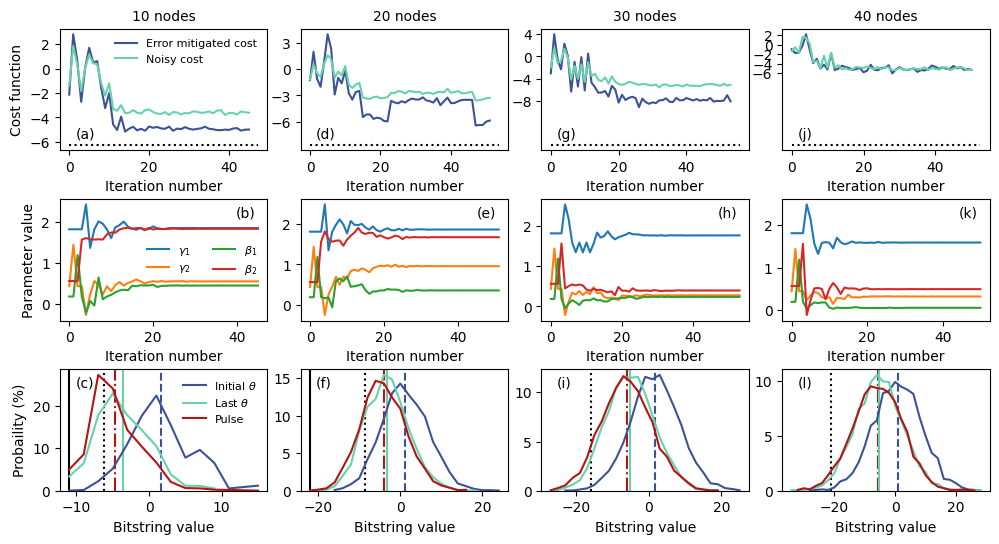

In [4]:
fig, axs = plt.subplots(3, len(data_sets), figsize=(12, 6))

summary_lines = []
for idx, (nnodes, tag, dtag) in enumerate(data_sets):

    print(f"\n{nnodes} nodes graph")
    
    data_file = f"../data/results/{nnodes}nodes/{dtag}_{tag}_{backend_name}_qaoa_data.json"
    qaoa_data = json.load(open(data_file, "r"))
    
    axs[0][idx].plot(qaoa_data["mitigated_cost"], label="Error mitigated cost", color=[60/255, 82/255, 150/255])
    axs[0][idx].plot(qaoa_data["noisy_cost"], label="Noisy cost", color=[102/255, 210/255, 172/255])
    axs[0][idx].set_xlabel("Iteration number")
    
    axs[0][idx].set_yticks(yticks[idx])
    
    for param_idx, label in enumerate([r"$\gamma_1$", r"$\gamma_2$", r"$\beta_1$", r"$\beta_2$"]):
        axs[1][idx].plot([val[param_idx] for val in qaoa_data["parameters"]], label=label)
        axs[1][idx].set_xlabel("Iteration number")
    
    data = json.load(open(qaoa_data["graph_file"], "r"))

    em_qaoa = qaoa.ErrorMitigationQAOA(
        shots=4096,
        path=[],
        local_correlators=data["paulis"],
        backend=None,#backend,
    )
    
    best_idx = np.argmin(qaoa_data["mitigated_cost"])
    
    costs_i, freqs_i = make_cost_histo(qaoa_data["counts"][0], em_qaoa, "Initial point:  ")
    costs_f, freqs_f = make_cost_histo(qaoa_data["counts"][-1], em_qaoa, "Final point:    ")
    
    if pulse_data is not None:
        costs_p, freqs_p = make_cost_histo(pulse_data[str(nnodes)]["counts"], em_qaoa, "Pulse efficient:")
        avg_p = sum(cost * freqs_p[idx] for idx, cost in enumerate(costs_p) ) / 100
    else:
        avg_p = None
    
    avg_i = sum(cost * freqs_i[idx] for idx, cost in enumerate(costs_i) ) / 100
    avg_f = sum(cost * freqs_f[idx] for idx, cost in enumerate(costs_f) ) / 100
    
    graph = build_graph(data["paulis"])
    lc_qaoa = LightConeQAOA(graph, shots=1000)
    noiseless_lc = lc_qaoa.depth_two_qaoa(qaoa_data["parameters"][-1])
    
    if idx > -1:
        axs[2][idx].plot(costs_i, freqs_i, color=[ 60/255,  82/255, 150/255], linewidth=1.5, label=r"Initial $\theta$")
        axs[2][idx].plot(costs_f, freqs_f, color=[102/255, 210/255, 172/255], linewidth=1.5, label=r"Last $\theta$")
        
        if pulse_data is not None:
            axs[2][idx].plot(costs_p, freqs_p, color=[180/255, 20/255, 20/255], linewidth=1.5, label=r"Pulse")
    else:
        w = 0.8
        axs[2][idx].bar(
            [cost - w / 2 for cost in costs_i], freqs_i, width=w, color=[60/255, 82/255, 150/255], 
            edgecolor="royalblue", linewidth=0.5, label=r"Initial $\theta$"
        )
        axs[2][idx].bar(
            [cost + w / 2 for cost in costs_f], freqs_f, width=w, color=[102/255, 210/255, 172/255], 
            edgecolor="darkgreen", linewidth=0.5, label=r"Last $\theta$"
        )
    
    axs[2][idx].set_xlabel("Bitstring value")
    axs[0][idx].set_title(f"{nnodes} nodes", fontsize=10)
    
    ylims = axs[2][idx].get_ylim()
    xlims = axs[0][idx].get_xlim()
    axs[2][idx].vlines(noiseless_lc, 0, ylims[1], ls=":", color="k", zorder=-10*idx)
    axs[0][idx].hlines(noiseless_lc, 0, xlims[1], ls=":", color="k", zorder=-10*idx)
    
    if pulse_data is not None:
        axs[2][idx].vlines(avg_p, 0, ylims[1], color=[180/255, 20/255, 20/255], ls="dashdot", zorder=-10)
    
    # Compute the maximum cut
    max_cut = Maxcut(nx.adjacency_matrix(graph))
    problem = max_cut.to_quadratic_program()

    optimizer = CplexOptimizer()
    cplex_result = optimizer.solve(problem)

    mce = -2*cplex_result.fval + len(graph.edges)  # max-cut energy
    
    best_approx = -2 * 0.9326 * cplex_result.fval + len(graph.edges)  # max-cut energy
    
    if idx < 2:
        axs[2][idx].vlines(mce, 0, ylims[1], color="k", zorder=-10)
    
    # Add vlines for the initial and final points
    axs[2][idx].vlines(avg_i, 0, ylims[1], color=[60/255, 82/255, 150/255], ls="--", zorder=-10)
    axs[2][idx].vlines(avg_f, 0, ylims[1], color=[102/255, 210/255, 172/255], zorder=-10)
    axs[2][idx].set_ylim([0, ylims[1]])
    
    if idx == 0:
        axs[0][idx].legend(loc=1, fontsize=8, frameon=False)
        axs[2][idx].legend(fontsize=8, frameon=False)
        axs[1][idx].legend(ncol=2, frameon=False, fontsize=8)
        axs[0][idx].set_ylabel("Cost function")
        axs[1][idx].set_ylabel("Parameter value")
        axs[2][idx].set_ylabel("Probaility (%)")
    
    summary_lines.append([nnodes, avg_i, avg_f, avg_p, noiseless_lc, mce, cplex_result.fval, best_approx])
    
    axs[0][idx].text(0.075, 0.1, {0: "(a)", 1: "(d)", 2: "(g)", 3: "(j)"}[idx], transform = axs[0][idx].transAxes)
    axs[1][idx].text(0.85, 0.85, {0: "(b)", 1: "(e)", 2: "(h)", 3: "(k)"}[idx], transform = axs[1][idx].transAxes)
    axs[2][idx].text(0.075, 0.85, {0: "(c)", 1: "(f)", 2: "(i)", 3: "(l)"}[idx], transform = axs[2][idx].transAxes)

plt.subplots_adjust(wspace=0.16, hspace=0.4)

print("\nSummary")
print("nnodes", "avg_i", "avg_f", "avg_p", "noiseless_lc", "max-cut energy", "max-cut value", "best_approx")
for line in summary_lines:
    print(*line)